In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import re
import math
import matplotlib.pyplot as plt
import os
import re
from glob import glob

import pandas as pd
import csv

# ──── 設定 ─────────────────────────────────────────
BASE_DIR   = "./../result"
OUTPUT_DIR = "./../outputfolder"
LOG_PATTERN = "*_test_*.log"
TAG         = {'chewing':'g','swallowing':'e'}
OUTPUT_CSV = "./../metrics_csv/all_models_detailed_metrics.csv"


# 出力フォルダがなければ作成
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ログ中の損失抽出用パターン
pattern = re.compile(
    r"Epoch\s+(\d+)/\d+\s+\|\s+Train Loss:\s*([\d.]+)\s*\|\s+Val Loss:\s*([\d.]+)"
)

# 全結果を一時保存する辞書
all_results = {}

# ──── 各モデルごとの処理 ────────────────────────────────────
for model in sorted(os.listdir(BASE_DIR)):
    model_dir = os.path.join(BASE_DIR, model)
    log_path  = os.path.join(model_dir, f"{model}.log")

    if not os.path.isfile(log_path):
        print(f"[スキップ] ログなし: {log_path}")
        continue

    epochs, train_losses, val_losses = [], [], []

    with open(log_path, "r") as f:
        for line in f:
            m = pattern.search(line)
            if m:
                epochs.append(int(m.group(1)))
                train_losses.append(float(m.group(2)))
                val_losses.append(float(m.group(3)))

    if not epochs:
        print(f"[警告] 損失情報抽出失敗: {model}")
        continue

    # 個別プロット
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, marker="o", label="Train Loss")
    plt.plot(epochs, val_losses,   marker="s", label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model} Loss Curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    out_path = os.path.join(OUTPUT_DIR, f"{model}_loss.png")
    plt.savefig(out_path)
    plt.close()
    print(f"[完了] {model} の損失曲線を保存: {out_path}")

    # 辞書に保存
    all_results[model] = (epochs, train_losses, val_losses)

# ──── 全モデルまとめプロット ────────────────────────────────────
if all_results:
    models = list(all_results.keys())
    num_models = len(models)
    cols = 2
    rows = math.ceil(num_models / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
    axes = axes.flatten()

    for ax, model in zip(axes, models):
        epochs, t_loss, v_loss = all_results[model]
        ax.plot(epochs, t_loss, marker="o", label="Train")
        ax.plot(epochs, v_loss, marker="s", label="Val")
        ax.set_title(model)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.grid(True)
        ax.legend(fontsize="small")

    # 余ったサブプロットを消す
    for ax in axes[num_models:]:
        fig.delaxes(ax)

    plt.tight_layout()
    combined_path = os.path.join(OUTPUT_DIR, "combined_loss.png")
    plt.savefig(combined_path)
    plt.close()
    print(f"[完了] 全モデルまとめ画像を保存: {combined_path}")



[完了] wavlm_gru の損失曲線を保存: ./../outputfolder/wavlm_gru_loss.png
[完了] 全モデルまとめ画像を保存: ./../outputfolder/combined_loss.png


In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
BASE_DIR 配下の各モデルディレクトリから最新ログを解析し、
詳細メトリクスをまとめて 1 つの CSV に出力するスクリプト
"""


# ログファイル名のパターン
LOG_PATTERN = "*_test_*.log"

# クラスタグ
TAG = {'chewing':'g', 'swallowing':'e'}

def find_latest_log(model_dir):
    """モデルディレクトリ内の最新ログファイルを返す"""
    files = glob(os.path.join(model_dir, LOG_PATTERN))
    return max(files, key=os.path.getmtime) if files else None

def parse_log(path):
    """1つのログファイルをパースし、詳細メトリクス行をリストで返す"""
    meta = {
        'model': None,
        'total_params': None,
        'inference_time_sec': None,
        'throughput': None,
        'matched_iou_chewing': None,
        'matched_iou_swallowing': None
    }
    results = []
    section = None
    cls = None

    with open(path, encoding='utf-8') as f:
        for raw in f:
            line = re.sub(r"^\d{4}-\d{2}-\d{2}.*?\[INFO\]\s*", "", raw).strip()
            if not line:
                continue

            # --- メタデータ抽出 ---
            m = re.search(r"===\s*テストモード:\s*(\S+)", line)
            if m:
                meta['model'] = m.group(1)
                continue

            m = re.search(r"Total parameters:\s*([\d,]+)", line)
            if m:
                meta['total_params'] = int(m.group(1).replace(',', ''))
                continue

            m = re.search(r"テスト評価完了.*所要時間[:：]\s*([0-9]+):([0-9]+):([0-9\.]+)", line)
            if m:
                h, mi, s = m.groups()
                meta['inference_time_sec'] = int(h)*3600 + int(mi)*60 + float(s)
                continue

            m = re.search(r"Throughput:\s*([\d\.]+)\s*samples/sec", line)
            if m:
                meta['throughput'] = float(m.group(1))
                continue

            # Matched IoU
            if line.startswith("=== Matched IoU"):
                section = 'matched'
                continue
            if section == 'matched':
                m2 = re.match(r"(chewing|swallowing)\s*[:：]\s*([\d\.]+)", line)
                if m2:
                    cls_name, val = m2.groups()
                    meta[f'matched_iou_{cls_name}'] = float(val)
                if line.startswith("===") and not line.startswith("=== Matched IoU"):
                    section = None
                continue

            # --- 詳細スコア抽出 ---
            m = re.search(r"---\s*(.+?)\s*---", line)
            if m:
                section = m.group(1)
                cls = None
                continue

            m = re.search(r"([a-zA-Z]+)\s+クラス:", line)
            if m:
                name = m.group(1).lower()
                cls = name if name in TAG else None
                continue

            m = re.search(
                r"IoU\s*>\s*([\d\.~e\-\+]+)\s*\|\s*P:\s*([\d\.]+)\s*,\s*R:\s*([\d\.]+)\s*,\s*F1:\s*([\d\.]+)",
                line
            )
            if m and section and cls:
                iou, p, r, f1 = m.groups()
                row = {
                    **meta,
                    'section': section,
                    'class': cls,
                    'tag': TAG[cls],
                    'iou': iou,
                    'precision': p,
                    'recall': r,
                    'f1': f1
                }
                results.append(row)
                continue

    return results

def write_csv(rows, headers, outpath):
    """ディレクトリを作成し、CSV を書き出す"""
    os.makedirs(os.path.dirname(outpath), exist_ok=True)
    with open(outpath, 'w', newline='', encoding='utf-8') as f:
        w = csv.DictWriter(f, fieldnames=headers)
        w.writeheader()
        for r in rows:
            w.writerow(r)

def main():
    all_rows = []
    for model in sorted(os.listdir(BASE_DIR)):
        model_dir = os.path.join(BASE_DIR, model)
        if not os.path.isdir(model_dir):
            continue

        log_file = find_latest_log(model_dir)
        if not log_file:
            print(f"[Warning] ログが見つかりません: {model_dir}")
            continue

        print(f"解析中: {model} ({os.path.basename(log_file)})")
        rows = parse_log(log_file)
        if not rows:
            print(f"  → 詳細メトリクスが見つかりません: {model}")
            continue

        all_rows.extend(rows)

    if not all_rows:
        print("いずれのモデルでもメトリクスが見つかりませんでした。")
        return

    # CSV ヘッダ
    meta_keys = [
        'model',
        'total_params',
        'inference_time_sec',
        'throughput',
        'matched_iou_chewing',
        'matched_iou_swallowing'
    ]
    detailed_headers = meta_keys + ['section', 'class', 'tag', 'iou', 'precision', 'recall', 'f1']

    write_csv(all_rows, detailed_headers, OUTPUT_CSV)
    print(f"\n全モデルの詳細メトリクスをまとめて出力しました: {OUTPUT_CSV}")

if __name__ == '__main__':
    main()


解析中: wavlm_gru (wavlm_gru_test_results.log)

全モデルの詳細メトリクスをまとめて出力しました: ./../metrics_csv/all_models_detailed_metrics.csv


In [4]:
import pandas as pd
import numpy as np

# CSV ファイルのパス
csv_path = "/home/tsukagoshitoshihiro/workspace/GCCE2025/experiment/metrics_csv/all_models_detailed_metrics.csv"

# CSV を読み込んで DataFrame に
df = pd.read_csv(csv_path)

# セクション名を整形
df['section'] = df['section'].replace({'全体結果': 'all'})

# 元の iou 表記の "~" を除去して float に変換
df['iou_raw'] = df['iou'].str.lstrip('~').astype(float)

# 閾値表記にフォーマット
def format_iou_threshold(x):
    if x < 1e-6:
        return '>0.0'
    cat = round(x * 10) / 10
    return f'>{cat:.1f}'

df['iou'] = df['iou_raw'].map(format_iou_threshold)

# ダミーラベル列を追加（model_section）
df['label'] = df['model'] + '_' + df['section']



In [5]:
df

,model,total_params,inference_time_sec,throughput,matched_iou_chewing,matched_iou_swallowing,section,class,tag,iou,precision,recall,f1,iou_raw,label
0,gru_mel,626691,2.002493,199.76,0.547,0.757,all,chewing,g,>0.0,0.919,0.706,0.799,2.200000e-16,gru_mel_all
1,gru_mel,626691,2.002493,199.76,0.547,0.757,all,chewing,g,>0.1,0.892,0.685,0.775,1.000000e-01,gru_mel_all
2,gru_mel,626691,2.002493,199.76,0.547,0.757,all,chewing,g,>0.2,0.843,0.648,0.733,2.000000e-01,gru_mel_all
3,gru_mel,626691,2.002493,199.76,0.547,0.757,all,chewing,g,>0.3,0.772,0.593,0.671,3.000000e-01,gru_mel_all
4,gru_mel,626691,2.002493,199.76,0.547,0.757,all,chewing,g,>0.4,0.672,0.516,0.583,4.000000e-01,gru_mel_all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2305,wavlm_lstm,95370099,4.363951,91.66,0.658,0.816,w20,swallowing,e,>0.6,0.941,0.930,0.936,6.000000e-01,wavlm_lstm_w20
2306,wavlm_lstm,95370099,4.363951,91.66,0.658,0.816,w20,swallowing,e,>0.7,0.906,0.895,0.901,7.000000e-01,wavlm_lstm_w20
2307,wavlm_lstm,95370099,4.363951,91.66,0.658,0.816,w20,swallowing,e,>0.8,0.835,0.826,0.830,8.000000e-01,wavlm_lstm_w20
2308,wavlm_lstm,95370099,4.363951,91.66,0.658,0.816,w20,swallowing,e,>0.9,0.635,0.628,0.632,9.000000e-01,wavlm_lstm_w20


In [6]:
# IoU>0.0 & section='all' でクラス別にランキングを作成・表示する例

import pandas as pd

# ▶ ご自身の環境に合わせてパスを修正してください
csv_path = "/home/tsukagoshitoshihiro/workspace/GCCE2025/experiment/metrics_csv/all_models_detailed_metrics.csv"

# データ読み込み
df = pd.read_csv(csv_path)

# セクション名を整形
df['section'] = df['section'].replace({'全体結果': 'all'})

# "~" を除去して float に変換
df['iou_raw'] = df['iou'].str.lstrip('~').astype(float)
df['f1']      = df['f1'].astype(float)

# 対象セクション＆閾値フィルタ
mask = (df['iou_raw'] > 0) & (df['section'] == 'all')

for cls in ['chewing', 'swallowing']:
    df_cls = (
        df[mask & (df['class'] == cls)]
        .sort_values('f1', ascending=False)
        .reset_index(drop=True)
    )

    # 表示用にカラムを選択・リネーム
    df_out = df_cls[['model', 'iou_raw', 'f1']].rename(
        columns={
            'model': 'Model',
            'iou_raw': 'IoU',
            'f1': 'F1 Score'
        }
    )

    print(f"\n=== {cls.upper()} Ranking (IoU>0.0, section='all') ===")
    print(df_out.to_string(index=False))



=== CHEWING Ranking (IoU>0.0, section='all') ===
           Model          IoU  F1 Score
 wavlm_gru_75pct 2.200000e-16     0.966
 wavlm_gru_50pct 2.200000e-16     0.965
      wavlm_lstm 2.200000e-16     0.963
 wavlm-base-plus 2.200000e-16     0.962
 wavlm_gru_25pct 2.200000e-16     0.960
  hubert-base_fc 2.200000e-16     0.959
     hubert-base 2.200000e-16     0.958
        wavlm_fc 2.200000e-16     0.955
 wavlm_gru_50pct 1.000000e-01     0.955
         gru_raw 2.200000e-16     0.954
 wavlm_gru_75pct 1.000000e-01     0.953
 wavlm-base-plus 1.000000e-01     0.952
       wavlm_gru 2.200000e-16     0.951
      wavlm_lstm 1.000000e-01     0.949
     wavlm-large 2.200000e-16     0.949
   wav2vec2-base 2.200000e-16     0.947
 wavlm_gru_10pct 2.200000e-16     0.947
  wav2vec2-large 2.200000e-16     0.947
 wavlm_gru_25pct 1.000000e-01     0.946
     hubert-base 1.000000e-01     0.944
        wavlm_fc 1.000000e-01     0.940
  hubert-base_fc 1.000000e-01     0.940
         gru_raw 1.000000e-01 

In [7]:
# IoU>0.0 & section="all" のランキングに推論時間・パラメタ数を含めて出力する例

import pandas as pd

# ▶ 実際の CSV ファイルパスに書き換えてください
csv_path = "/home/tsukagoshitoshihiro/workspace/GCCE2025/experiment/metrics_csv/all_models_detailed_metrics.csv"

# 1. データ読み込み
df = pd.read_csv(csv_path)

# 2. セクション名を整形
df['section'] = df['section'].replace({'全体結果': 'all'})

# 3. "~" を除去して float に変換
df['iou_raw']     = df['iou'].str.lstrip('~').astype(float)
df['f1']          = df['f1'].astype(float)

# 4. パラメタ数、推論時間を適切な型に変換
df['total_params']         = df['total_params'].astype(int)
df['inference_time_sec']   = df['inference_time_sec'].astype(float)

# 5. 共通フィルタ：IoU>0.0 & section='all'
mask = (df['iou_raw'] > 0) & (df['section'] == 'all')

# 6. クラス別にランキングを作成
for cls in ['chewing', 'swallowing']:
    df_cls = (
        df[mask & (df['class'] == cls)]
        .sort_values('f1', ascending=False)
        .reset_index(drop=True)
    )

    # 7. 表示用に必要なカラムを選択・リネーム
    df_out = df_cls[[
        'model',
        'total_params',
        'inference_time_sec',
        'iou_raw',
        'f1'
    ]].rename(columns={
        'model':               'Model',
        'total_params':        'Parameters',
        'inference_time_sec':  'Inference Time (s)',
        'iou_raw':             'IoU',
        'f1':                  'F1 Score'
    })

    # 8. タイトルとともにコンソール出力
    print(f"\n=== {cls.upper()} Ranking (IoU>0.0, section='all') ===")
    print(df_out.to_string(index=False))



=== CHEWING Ranking (IoU>0.0, section='all') ===
           Model  Parameters  Inference Time (s)          IoU  F1 Score
 wavlm_gru_75pct    95172467            4.690406 2.200000e-16     0.966
 wavlm_gru_50pct    95172467            4.227264 2.200000e-16     0.965
      wavlm_lstm    95370099            4.363951 2.200000e-16     0.963
 wavlm-base-plus    95172467            4.246383 2.200000e-16     0.962
 wavlm_gru_25pct    95172467            4.244097 2.200000e-16     0.960
  hubert-base_fc    94569347            3.874352 2.200000e-16     0.959
     hubert-base    95162243            3.884933 2.200000e-16     0.958
        wavlm_fc    94579571            4.184196 2.200000e-16     0.955
 wavlm_gru_50pct    95172467            4.227264 1.000000e-01     0.955
         gru_raw    95172467            4.240706 2.200000e-16     0.954
 wavlm_gru_75pct    95172467            4.690406 1.000000e-01     0.953
 wavlm-base-plus    95172467            4.246383 1.000000e-01     0.952
       wavlm_g

## visualization

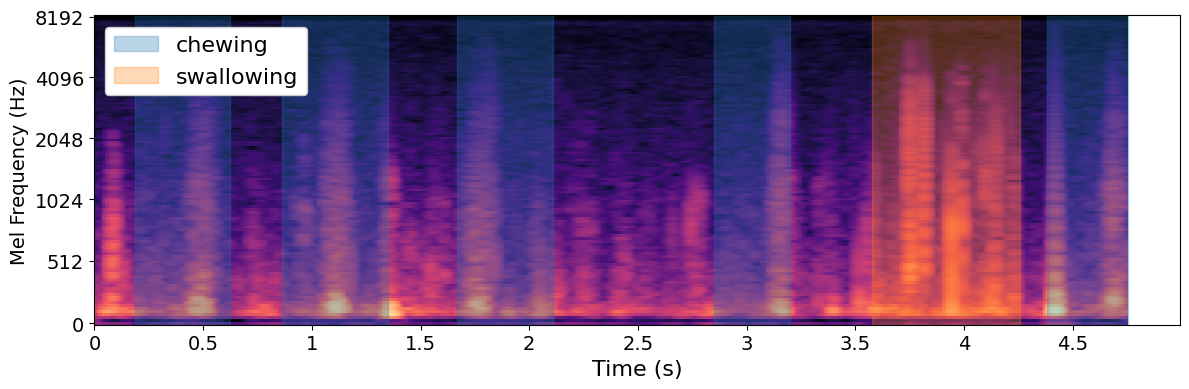

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display as ld
import soundfile as sf

# ===== ここだけ書き換えてください =====

wav_path   = "./../dataset/old_wav_aug/conbined/eat_MDK01_conbined_CBG_0115_54.wav"
label_path = "./../dataset/old_text_aug/eat_MDK01_CBG_0115_54.txt"
t_range    = (5, 10)        # 可視時間範囲（秒）
# =====================================

# ---------- Audacity 相当パラメータ ----------
WIN_LEN     = 2048
PAD_FACTOR  = 2
N_FFT       = WIN_LEN * PAD_FACTOR
HOP_LENGTH  = WIN_LEN // 20
WINDOW      = "hann"
N_MELS      = 128
FMAX        = 8192       
GAIN_DB     = 20
RANGE_DB    = 80
FMIN        = 1.0

PALETTE = {"ch": "tab:blue", "sw": "tab:orange"}  # chewing / swallowing

# ---------- ユーティリティ ----------
def read_intervals(txt_path):
    return [
        (float(s), float(e), tag)
        for s, e, tag in (ln.split() for ln in open(txt_path, encoding="utf-8") if ln.strip())
    ]

def clip_interval(intv, start, end):
    s, e, tag = intv
    if e < start or s > end:
        return None
    return max(s, start), min(e, end), tag

# ---------- メイン ----------
def plot_audacity_like(wav_path, label_path, t_range=None):
    y, sr = sf.read(wav_path)
    if y.ndim > 1:
        y = y.mean(axis=1)

    full_len = len(y) / sr
    if t_range:
        t0, t1 = max(0, t_range[0]), min(full_len, t_range[1])
        y = y[int(t0 * sr): int(t1 * sr)]
    else:
        t0, t1 = 0, full_len

    # --- log-Mel ---
    S = librosa.feature.melspectrogram(
        y=y, sr=sr,
        n_fft=N_FFT, hop_length=HOP_LENGTH,
        win_length=WIN_LEN, window=WINDOW,
        n_mels=N_MELS, fmin=FMIN, fmax=FMAX,
        power=2.0
    )
    S_db = librosa.power_to_db(S, ref=np.max) + GAIN_DB
    vmax = S_db.max()
    vmin = vmax - RANGE_DB

    # --- 描画 ---
    fig, ax = plt.subplots(figsize=(12, 4))
    ld.specshow(
        S_db, sr=sr, hop_length=HOP_LENGTH,
        x_axis="time", y_axis="mel",  # ← メル周波数
        fmin=FMIN, fmax=FMAX, cmap="magma",
        vmin=vmin, vmax=vmax, ax=ax
    )
    ax.set_ylabel("Mel Frequency (Hz)", fontsize=14)
    ax.set_xlabel("Time (s)", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

    # --- ラベル帯 ---
    alias = {"ch": "chewing", "sw": "swallowing"}
    for intv in read_intervals(label_path):
        clipped = clip_interval(intv, t0, t1) if t_range else intv
        if clipped is None:
            continue
        s_c, e_c, tag = clipped
        ax.axvspan(
            s_c - t0, e_c - t0,
            alpha=0.30, color=PALETTE.get(tag, "tab:red"),
            label=alias.get(tag, tag)
        )

    # --- 凡例（重複排除）---
    handles, labels = ax.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    leg = ax.legend(uniq.values(), uniq.keys(),
                    loc="upper left", frameon=True, fontsize=16)
    leg.get_frame().set_facecolor("white")
    leg.get_frame().set_alpha(1.0)

    plt.tight_layout()
    plt.show()

# ---------- 実行 ----------
plot_audacity_like(wav_path, label_path, t_range)


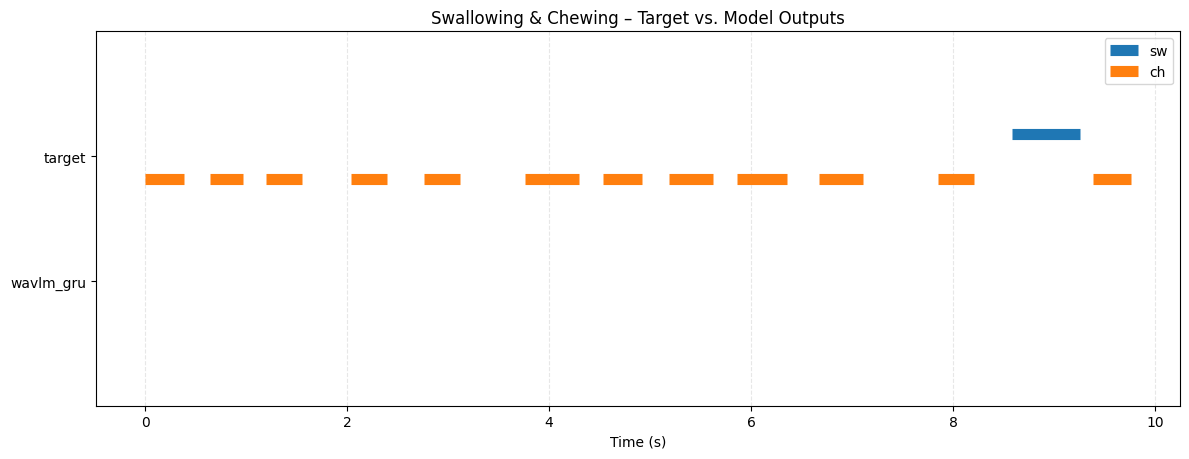

In [13]:
#!/usr/bin/env python3
# =============================================================================
# Swallowing-Label Comparator
# -----------------------------------------------------------------------------
# ❶ 使い方 ― ノートブックにそのまま実行
#    - base_dir   : <フォルダ>/model_name/test_inference/ にラベルが並ぶ親フォルダ
#    - target_txt : 教師 (target) ラベルファイル
#    - file_name  : 各モデル test_inference/ 内で比較したいラベルファイル名
#    - t_range    : 描画区間 (None なら音声全体). 例) (2.0, 10.0)
#
# ❷ フォルダ構成例
#       experiments/            ← base_dir
#           wavlm_gru/
#               test_inference/
#                   demo.txt    ← file_name
#           hubert_lstm/
#               test_inference/
#                   demo.txt
#           ...
#       target_labels/demo.txt  ← target_txt
#
# ❸ 実行後，ターゲットと全モデルの「嚥下 (sw) 区間」を横並び比較する図が表示されます
# =============================================================================
import os, matplotlib.pyplot as plt

# ------------------------------- 設定 (ここだけ変更) -------------------------
base_dir   = "./../result"          # モデルディレクトリ親
target_txt = "./../dataset/old_text_aug/eat_MDK01_CBG_0115_54.txt"
file_name  = "eat_MDK01_conbined_CBG_0115_54.txt"                      # test_inference 内で比較するファイル名
t_range    = None                            # 例) (2.0, 12.0) で拡大，None で全体
tag_key    = ("sw", "swallowing")            # 嚥下を示すタグ表記
linewidth  = 10                              # 帯の太さ
# -----------------------------------------------------------------------------


exclude_models = ["wavlm_gru_75pct","wavlm_gru_50pct","wavlm_gru_25pct","wavlm_gru_10pct","wavlm-base-plus","wavlm_lstm"] # 非表示にしたいモデル dir 名 (リスト)
# include_models = ["wavlm_gru", ...]# ← これを設定した場合はこのリストだけ表示

tags_to_plot = {                     # {内部キー: (複数表記, …)} で表記ゆれ対応
    "sw": ("sw", "swallow", "swallowing"),
    "ch": ("ch", "chew", "chewing"),
}
tag_palette = {"sw": "tab:blue", "ch": "tab:orange"}
tag_offsets = {"sw":  0.18,          # y 方向のずらし量 (+上, −下)
               "ch": -0.18}
linewidth    = 8                     # バー太さ
# -----------------------------------------------------------------------------


# --------------------------- ヘルパ関数群 -----------------------------------
def collect_label_sets(base_dir, target_txt, file_name,
                       exclude=None, include=None):
    """モデル dir を自動収集して {名前: txt_path} を返す"""
    label_sets = {"target": target_txt}
    for d in sorted(os.listdir(base_dir)):
        if exclude and d in exclude:
            continue
        if include and d not in include:
            continue
        cand = os.path.join(base_dir, d, "test_inference", file_name)
        if os.path.isfile(cand):
            label_sets[d] = cand
    if len(label_sets) <= 1:
        raise RuntimeError("モデルラベルが見つかりません。パス／file_name を確認してください。")
    return label_sets


def read_intervals(txt_path, tags_to_plot):
    """txt→ {tag_key: [(s,e)...]}  (存在しない tag_key は空リスト)"""
    out = {k: [] for k in tags_to_plot}
    with open(txt_path, encoding="utf-8") as f:
        for ln in f:
            if not ln.strip():
                continue
            s, e, tag = ln.split()
            s, e = float(s), float(e)
            for k, aliases in tags_to_plot.items():
                if tag.lower() in aliases:
                    out[k].append((s, e))
    return out


def clip_segment(seg, start, end):
    """(s,e) を [start,end] でクリップ（重なりゼロなら None）"""
    s, e = seg
    if e < start or s > end:
        return None
    return max(s, start), min(e, end)


def plot_tracks(label_sets, tags_to_plot, t_range=None,
                palette=None, offsets=None, linewidth=8):
    data = {name: read_intervals(path, tags_to_plot)
            for name, path in label_sets.items()}
    y_base = {name: idx for idx, name in enumerate(reversed(data.keys()))}

    fig, ax = plt.subplots(figsize=(12, 4 + 0.35*len(data)))
    for name, tag_dict in data.items():
        y0 = y_base[name]
        for tag, segs in tag_dict.items():
            for s, e in segs:
                if t_range:
                    clipped = clip_segment((s, e), *t_range)
                    if clipped is None:
                        continue
                    s, e = clipped
                y = y0 + (offsets.get(tag, 0) if offsets else 0)
                ax.hlines(y, s, e, linewidth=linewidth,
                          color=palette.get(tag, "gray"),
                          label=tag if (s == segs[0][0] and name == "target") else "")

    # 軸と凡例
    ax.set_xlabel("Time (s)")
    ax.set_yticks(list(y_base.values()))
    ax.set_yticklabels(reversed(list(data.keys())))
    if t_range:
        ax.set_xlim(*t_range)
    ax.set_ylim(-1, len(data))
    ax.grid(axis="x", linestyle="--", alpha=0.3)
    ax.set_title('Swallowing & Chewing – Target vs. Model Outputs')

    handles, labels = ax.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    ax.legend(uniq.values(), uniq.keys(), loc="upper right")
    plt.tight_layout()
    plt.show()


# ------------------------------- 実 行 ---------------------------------------
label_sets = collect_label_sets(
    base_dir, target_txt, file_name,
    exclude=exclude_models,
    # include=include_models,  # ← include を使う場合はコメント解除
)

plot_tracks(label_sets, tags_to_plot, t_range=t_range,
            palette=tag_palette, offsets=tag_offsets, linewidth=linewidth)


/tmp/ipykernel_741185/897070793.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.95])


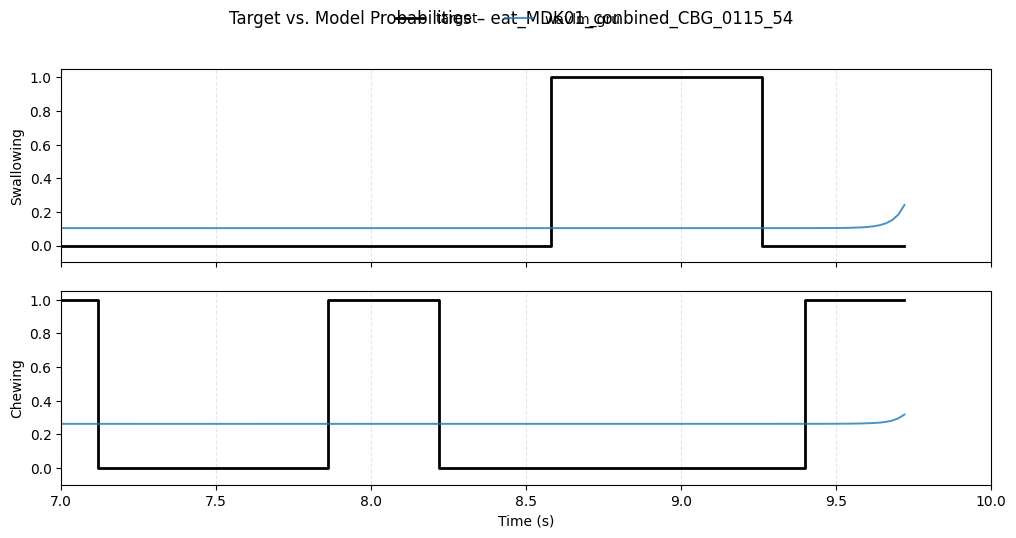

In [15]:
#!/usr/bin/env python3
# =============================================================================
# Swallow/Chew Probability Visualizer  (length-mismatch safe)
# =============================================================================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

# ------------------------------- 設定 -------------------------------
base_dir   = "./../result"
target_txt = "./../dataset/old_text_aug/eat_MDK01_CBG_0115_54.txt"
file_stem  = "eat_MDK01_conbined_CBG_0115_54"     # stem → stem_probas.tsv
t_range    = (7,10)
exclude_models = ["wavlm_gru_75pct","wavlm_gru_50pct",
                  "wavlm_gru_25pct","wavlm_gru_10pct",
                  "wavlm-base-plus","wavlm_lstm"]
# include_models = ["wavlm_gru", ...]            # ← 使う場合はコメント解除
# --------------------------------------------------------------------

TAG_ALIASES = {"sw": ("sw", "swallow", "swallowing"),
               "ch": ("ch", "chew", "chewing")}
PROB_SUFFIX = "_probs.tsv"
TARGET_LW, MODEL_LW = 2.0, 1.4

def collect_prob_paths(base, stem, exc=None, inc=None):
    paths = {}
    for d in sorted(os.listdir(base)):
        if exc and d in exc:         continue
        if inc and d not in inc:     continue
        p = os.path.join(base, d, "test_frame_probs", stem + PROB_SUFFIX)
        if os.path.isfile(p):        paths[d] = p
    if not paths:
        raise RuntimeError("*_probs.tsv が見つかりません。stem / ディレクトリを確認してください。")
    return paths

def read_intervals(path, aliases):
    out = {k: [] for k in aliases}
    with open(path, encoding="utf-8") as f:
        for ln in f:
            if not ln.strip():           continue
            s, e, tag = ln.split()
            s, e = float(s), float(e)
            for k, names in aliases.items():
                if tag.lower() in names: out[k].append((s, e))
    return out

def intervals_to_binary(time, intervals):
    y = np.zeros_like(time, dtype=float)
    for s, e in intervals:
        idx = np.where((time >= s) & (time <= e))
        y[idx] = 1.0
    return y

# ------------------------- データ読み込み ---------------------------
prob_paths = collect_prob_paths(base_dir, file_stem, exclude_models, None)

# まず全モデルの DataFrame を読む（タブ/スペース自動）
dfs = {}
for m, p in prob_paths.items():
    dfs[m] = pd.read_csv(p, sep=None, engine='python')

# “共通最小長” を決定
min_len = min(len(df) for df in dfs.values())

# 時間軸（最初の DF の先頭 min_len）
time_vec = dfs[next(iter(dfs))]['time_s'].values[:min_len]

# ターゲット 0/1
intervals = read_intervals(target_txt, TAG_ALIASES)
target_bin = {k: intervals_to_binary(time_vec, v) for k, v in intervals.items()}

# モデルの尤度
model_probs = {}
for m, df in dfs.items():
    df = df.iloc[:min_len]
    col_sw = 'swallowing' if 'swallowing' in df.columns else 'sw'
    model_probs[m] = {'sw': df[col_sw].values,
                      'ch': df['chewing'].values}

# -------------------------- 描 画 ------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(12, 5 + 0.4*len(model_probs)),
                         sharex=True, gridspec_kw=dict(hspace=0.15))
for ax, tag, title in zip(axes, ['sw','ch'], ['Swallowing','Chewing']):
    ax.step(time_vec, target_bin[tag], where='post',
            color='black', lw=TARGET_LW, label='target')
    for m, probs in model_probs.items():
        ax.plot(time_vec, probs[tag], lw=MODEL_LW, label=m, alpha=0.8)
    ax.set_ylabel(title); ax.set_ylim(-0.1, 1.05); ax.grid(axis='x', ls='--', alpha=0.3)
    if t_range: ax.set_xlim(*t_range)

axes[-1].set_xlabel("Time (s)")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',
           ncol=min(4, len(labels)), frameon=False)
fig.suptitle(f"Target vs. Model Probabilities – {file_stem}", y=0.99)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


Saved → swallowing_plot.png


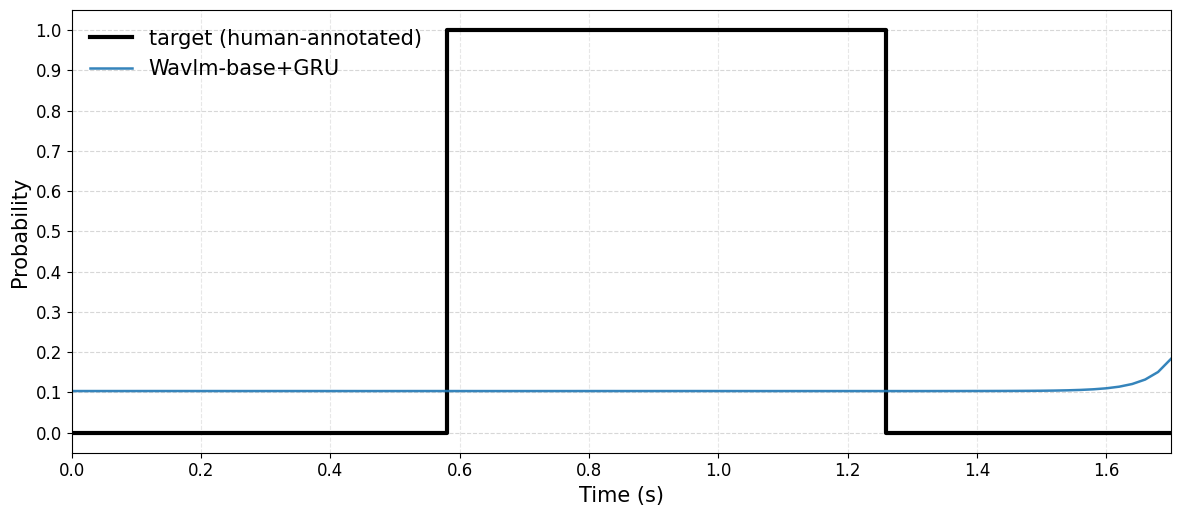

In [16]:
#!/usr/bin/env python3
# =============================================================================
# Swallowing-Probability Plotter  (single-panel, unified labels)
# =============================================================================
import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib import ticker

# --------------------------------------------------------------------------
# 設定
# --------------------------------------------------------------------------
base_dir   = "./../result"
target_txt = "./../dataset/old_text_aug/eat_MDK01_CBG_0115_54.txt"
file_stem  = "eat_MDK01_conbined_CBG_0115_54"   # stem → *_probs.tsv
t_range    = (8, 9.7)                            # (start, end)
exclude_models = ["wavlm_gru_75pct", "wavlm_gru_50pct",
                  "wavlm_gru_25pct", "wavlm_gru_10pct",
                  "wavlm-base-plus", "wavlm_lstm", "gru_raw",
                  "gru_mfcc", "hubert-large",
                  "wavlm-large", "wav2vec2-large", "wav2vec2-base_fc","hubert-base_fc",  "mel_crnn", "raw_crnn"]
save_png   = "swallowing_plot.png"
legend_loc = dict(loc="upper left", fontsize=15)

# --------------------------------------------------------------------------
# 1) 統一ラベル変換
# --------------------------------------------------------------------------
LABEL_MAP = {
    "mel_gru": "MelSpec+GRU",
    "gru_mel": "MelSpec+GRU",
    "mfcc_gru": "MFCC+GRU",
    "hubert-large_gru": "HuBERT-large+GRU",
    "hubert_large_gru": "HuBERT-large+GRU",
    "hubert-base": "HuBERT-base+GRU",
    "wavlm-large_gru": "WavLM-large+GRU",
    "wavlm_base_fc": "WavLM-base+FC",
    "wavlm-base_fc": "WavLM-base+FC",
    "wavlm-base_gru": "WavLM-base+GRU",
    "wav2vec2-large": "Wav2Vec2-large+GRU",
    "wav2vec2-base": "Wav2Vec2-base+GRU",
    "mfcc_crnn": "CNN+GRU(CRNN)",
}

def pretty_label(raw: str) -> str:
    if raw in LABEL_MAP:
        return LABEL_MAP[raw]
    m = re.match(r"(wavlm|wav2vec2|hubert)[-_]?([a-z]+)?[_-](gru|fc)", raw)
    if m:
        front, size, head = m.groups()
        front = front.capitalize() if front != "wav2vec2" else "Wav2Vec2"
        size  = size or "base"
        head  = head.upper()
        return f"{front}-{size}+{head}"
    return raw

# --------------------------------------------------------------------------
# 2) データ読み込みユーティリティ
# --------------------------------------------------------------------------
TAG_ALIASES = {"sw": ("sw", "swallow", "swallowing")}
PROB_SUFFIX = "_probs.tsv"
TARGET_LW, MODEL_LW = 3.0, 1.8

def collect_prob_paths(base, stem, exc=None, inc=None):
    paths = {}
    for d in sorted(os.listdir(base)):
        if exc and d in exc:  continue
        if inc and d not in inc: continue
        p = os.path.join(base, d, "test_frame_probs", stem + PROB_SUFFIX)
        if os.path.isfile(p): paths[d] = p
    if not paths:
        raise RuntimeError("*_probs.tsv が見つかりません。stem / ディレクトリを確認してください。")
    return paths

def read_intervals(path, aliases):
    out = {k: [] for k in aliases}
    with open(path, encoding="utf-8") as f:
        for ln in f:
            if not ln.strip(): continue
            s, e, tag = ln.split()
            s, e = float(s), float(e)
            for k, names in aliases.items():
                if tag.lower() in names: out[k].append((s, e))
    return out

def intervals_to_binary(time, intervals):
    y = np.zeros_like(time, dtype=float)
    for s, e in intervals:
        idx = np.where((time >= s) & (time <= e))
        y[idx] = 1.0
    return y

# --------------------------------------------------------------------------
# 3) データ取得
# --------------------------------------------------------------------------
prob_paths = collect_prob_paths(base_dir, file_stem, exclude_models, None)
dfs = {m: pd.read_csv(p, sep=None, engine="python") for m, p in prob_paths.items()}
min_len = min(len(df) for df in dfs.values())
time_vec = dfs[next(iter(dfs))]["time_s"].values[:min_len]

intervals = read_intervals(target_txt, TAG_ALIASES)
target_sw = intervals_to_binary(time_vec, intervals["sw"])

model_probs = {}
for m, df in dfs.items():
    df = df.iloc[:min_len]
    col_sw = "swallowing" if "swallowing" in df.columns else "sw"
    model_probs[m] = df[col_sw].values

# --------------------------------------------------------------------------
# 4) 時間軸ズーム
# --------------------------------------------------------------------------
if t_range:
    t0, t1 = t_range
    mask = (time_vec >= t0) & (time_vec <= t1)
    time_plot = time_vec[mask] - t0
    target_sw = target_sw[mask]
    model_probs = {m: y[mask] for m, y in model_probs.items()}
else:
    time_plot = time_vec

# --------------------------------------------------------------------------
# 5) 描画
# --------------------------------------------------------------------------
plt.rcParams.update({
    "font.size": 13, "axes.labelsize": 15, "axes.titlesize": 16,
    "xtick.labelsize": 12, "ytick.labelsize": 12, "legend.frameon": False
})
fig_h = 5 + 0.35 * len(model_probs)
fig, ax = plt.subplots(figsize=(12, fig_h))

ax.step(time_plot, target_sw, where="post", color="black",
        lw=TARGET_LW, label="target (human-annotated)")

for raw_id, y in model_probs.items():
    ax.plot(time_plot, y, lw=MODEL_LW, label=pretty_label(raw_id), alpha=0.9)

ax.set_ylabel("Probability")
ax.set_xlabel("Time (s)")
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.grid(True, linestyle="--", alpha=0.5)
ax.set_ylim(-0.05, 1.05)
if t_range:
    ax.set_xlim(0, t_range[1] - t_range[0])
ax.grid(axis="x", linestyle="--", alpha=0.3)

ax.legend(**legend_loc)
plt.tight_layout()

if save_png:
    fig.savefig(save_png, dpi=300)
    print(f"Saved → {save_png}")

plt.show()
